In [1]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
pi = math.pi

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#functions

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [3]:
dataDir = '/Users/fponce/Documents/vdesert/VD_082819/data'
pattern_vdesert_data = "*.hdf5"

exp = 'VD_082819'

datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths[-1])
print(len(datapaths))

/Users/fponce/Documents/vdesert/VD_082819/data/data_2019-08-29-11-40-51.hdf5
13


In [4]:
#panels 
# [[-180.0,  -90.0], 1] 
# [[ -90.0,    0.0], 2]
# [[   0.0,   90.0], 4]
# [[  90.0,  180.0], 3]

In [5]:
#check for keys
for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    datasetNames = [n for n in f.keys()]
print(datasetNames)

['alicat_tsstamp', 'alicat_tstamps', 'angle', 'autostep_action_running', 'autostep_action_started', 'autostep_action_stopped', 'current_trial_index', 'elapsed_time', 'flow_action_running', 'flow_action_started', 'flow_action_stopped', 'init_angle', 'ledpanels_panels_arg1', 'ledpanels_panels_arg2', 'ledpanels_panels_arg3', 'ledpanels_panels_arg4', 'ledpanels_panels_arg5', 'ledpanels_panels_arg6', 'ledpanels_panels_command', 'ledpanels_ros_tstamps', 'magnotether_angle', 'magnotether_frame', 'magnotether_ros_tstamps', 'magnotether_tstamps', 'motion_data_position', 'motion_data_ros_tstamps', 'motion_data_seq', 'motion_data_setpoint', 'motion_data_time', 'motion_data_tstamps', 'name', 'panels_action_running', 'panels_action_started', 'panels_action_stopped', 'ros_tstamps', 'seq', 'trial_e_time', 'tstamps']


In [6]:
# for i in range(len(all_magnotether_angle)):
#     plt.figure()
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [7]:
#hdf5 -> np.arrays
all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)

In [8]:
#get ledpanels info

#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)
    
#make the ledpanels command a list
l_all_ledpanels_command = []
for i in range(len(datapaths)):
    l = all_ledpanels_command[i].tolist()
    l_all_ledpanels_command.append(l)
       
#get the idx of ledpanels commands
#getting set_pattern_id commands
#getting idx of the set_gain commands

all_idx_pat_command = []
all_idx_gain_command = []
for i in range(len(datapaths)):
    idx_pat_command = [i for i, x in enumerate(l_all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(l_all_ledpanels_command[i])
               if x == b'send_gain_bias']
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)

#get the timestamp and elapsed time of the set pattern id command
all_ros_tstamps_pat_id = []
all_ledpanels_elapsed_t_pat_id  = []
for i in range(len(all_idx_pat_command)):
    ros_tstamps_pat_id_file = []
    ledpanels_elapsed_t_pat_id_file = []
    for j in (all_idx_pat_command[i]):
        ros_tstamps_pat_id = all_ledpanels_ros_tstamps[i][j]
        ledpanels_elapsed_t_pat_id = all_ledpanels_elapsed_t[i][j]
        
        ros_tstamps_pat_id_file.append(ros_tstamps_pat_id)
        ledpanels_elapsed_t_pat_id_file.append(ledpanels_elapsed_t_pat_id)
        
    all_ros_tstamps_pat_id.append(ros_tstamps_pat_id_file)
    all_ledpanels_elapsed_t_pat_id.append(ledpanels_elapsed_t_pat_id_file)  

#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)

    
print(all_ledpanels_elapsed_t_pat_id[0])
print(all_pattern_id)
print(all_gains[0])

[0.0, 180.0466980934143, 185.0863242149353, 365.1469957828522, 370.18600487709045, 550.2476317882538, 555.2846615314484, 735.345132112503, 740.3853766918182, 920.4457700252533, 925.4858119487762]
[[6, 8, 4, 8, 8, 2, 2, 4, 4, 2, 2], [4, 8, 8, 5, 5, 8, 8, 2, 5, 8, 8], [1, 6, 6, 7, 7, 3, 3, 7, 7, 5, 5], [6, 6, 6, 2, 8, 1, 1, 8, 8, 3, 3], [6, 1, 6, 5, 5, 8, 8, 1, 1, 2, 2], [6, 6, 6, 1, 7, 2, 2, 6, 6, 4, 4], [8, 7, 7, 2, 2, 6, 6, 8, 8, 7, 7], [1, 4, 4, 6, 6, 4, 4, 1, 1, 3, 3], [1, 7, 4, 6, 6, 4, 4, 6, 6, 8, 8], [2, 7, 7, 4, 4, 1, 1, 5, 3, 8, 8], [2, 8, 8, 3, 3, 2, 2, 6, 6, 4, 4], [1, 6, 6, 7, 7, 3, 3, 4, 4, 6, 6], [8, 1, 1, 4, 4, 5, 5, 7, 1, 5, 5]]
[1, 0, 8, 0, 16, 0, 32, 0, 64, 0, 120]


In [9]:
# #plot timestamps if wanted
# all_magnotether_ros_tstamps
# all_ledpanels_ros_tstamps

#get elapsed time of some time stamps
# tsstamps = all_magnotether_ros_tstamps
# all_ts = []
# for i in range(len(tsstamps)):
#     ts_file = []
#     for j in range(len(tsstamps[i])):
#         t = tsstamps[i][j] - tsstamps[i][0]
#         ts_file.append(t)
#     all_ts.append(ts_file)

# #plot
# for i in range(len(all_ts)):
#     plt.figure(figsize = (15,7))
#     plt.xlim(0,35000)
#     plt.scatter(np.arange(0,len(all_ts[i])-1),np.diff(all_ts[i]))

# #plot timestamps vs angle

# tsstamps = all_magnotether_ros_tstamps
# for i in range(len(tsstamps)):
#     plt.figure(figsize = (15,7))
#     plt.scatter(tsstamps[i],all_magnotether_angle[i])
#     plt.axvline(x = all_ros_tstamps_pat_id[i][0], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][1], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][2], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][3], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][4], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][5], color = 'r')

In [10]:
#interpolation of magnotether angles
number_trials = 11
#trial_time = 185*number_trials
number_frames_per_sec = 30
trial_time = 1105 #sec
 
t = [0,trial_time]
print(trial_time*number_frames_per_sec)
reg_t = np.linspace(t[0], t[-1],(trial_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

33150


In [11]:
print(reg_t)

[0.00000000e+00 3.33333333e-02 6.66666667e-02 ... 1.10493333e+03
 1.10496667e+03 1.10500000e+03]


In [12]:
#this gets the times when the trial changes in the virtual desert node
all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range((number_trials)):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
# print(all_start_times[0])
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
# print(all_start_frames[0])
# print(all_end_frames[0])

In [13]:
#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
print(all_start_times_m[0])   
print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
print(all_start_frames_m[0])   
print(all_end_frames_m[0]) 

[0.4666666666666667, 180.46666666666667, 185.5, 365.56666666666666, 370.6, 550.6666666666666, 555.7, 735.7666666666667, 740.8, 920.8666666666667, 925.9]
[180.43333333333334, 185.5, 365.56666666666666, 370.6, 550.6666666666666, 555.7, 735.7666666666667, 740.8, 920.8666666666667, 925.9, 1105.0]
[14, 5414, 5565, 10967, 11118, 16520, 16671, 22073, 22224, 27626, 27777]
[5413, 5565, 10967, 11118, 16520, 16671, 22073, 22224, 27626, 27777, 33150]


In [14]:
#pattern key

# pattern_ids = [1,2,3,4,5,6,7,8]

# pattern_angles = [-135, 45, 135]

print(all_pattern_id[3])

[6, 6, 6, 2, 8, 1, 1, 8, 8, 3, 3]


In [15]:
#replace pattern_ids with angles in lab corrdinates

all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        if all_pattern_id[i][j]==1:
            p=-135
        elif all_pattern_id[i][j]==2:
            p=45
        elif all_pattern_id[i][j]==3:
            p=135
        elif all_pattern_id[i][j]==4:
            p=-45
        elif all_pattern_id[i][j]==5:
            p=90
        elif all_pattern_id[i][j]==6:
            p=180
        elif all_pattern_id[i][j]==7:
            p=-90
        elif all_pattern_id[i][j]==8:
            p=0
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)
print(all_pat_angles[3])

[180, 180, 180, 45, 0, -135, -135, 0, 0, 135, 135]


In [16]:
print(all_pat_angles[0][0])
# for i in range(len(all_magnotether_interp_angles)):
#     print(len(all_magnotether_interp_angles[i]))

180


In [17]:
# # plot and save raw data
# #allangles = all_magnotether_interp_angles

# # plot and save raw data
# for i in [12]: #range(len(allframes)):
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 50), facecolor='w', edgecolor='k')
#     #fig.subplots_adjust(hspace = .2, wspace=.09, bottom=0.1)
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.94,bottom=0.05 )
    
#     bckclr_labels = ['lavender']
    
#     gs = gridspec.GridSpec(6, 1)
    
#     ######################################################################################################
    
#     #trial 1 + 5 sec of static pattern
#     j = 0
#     ax1 = plt.subplot(gs[0, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax1.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.patch.set_facecolor(bckclr_labels[0])
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax1.spines['left'].set_smart_bounds(True)
#     ax1.spines['bottom'].set_smart_bounds(True)
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 2
#     ax2 = plt.subplot(gs[j-1, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax2.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax2.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax2.set_ylim([-200, 200])
#     ax2.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax2.set_yticks(np.arange(-180, 225,45))
#     ax2.yaxis.set_tick_params(labelsize=30)
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax2.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_smart_bounds(True)
#     ax2.spines['bottom'].set_smart_bounds(True)
#     ax2.spines['left'].set_linewidth(2)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 4
#     ax3 = plt.subplot(gs[j-2, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax3.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax3.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax3.spines['left'].set_smart_bounds(True)
#     ax3.spines['bottom'].set_smart_bounds(True)
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 6
#     ax4 = plt.subplot(gs[j-3, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax4.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax4.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax4.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax4.set_ylim([-200, 200])
#     ax4.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax4.set_yticks(np.arange(-180, 225,45))
#     ax4.yaxis.set_tick_params(labelsize=30)
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax4.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax4.spines['left'].set_smart_bounds(True)
#     ax4.spines['bottom'].set_smart_bounds(True)
#     ax4.spines['left'].set_linewidth(2)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 8
#     ax5 = plt.subplot(gs[j-4, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j+1]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax5.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax5.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax5.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax5.spines['left'].set_smart_bounds(True)
#     ax5.spines['bottom'].set_smart_bounds(True)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 10
#     ax6 = plt.subplot(gs[j-5, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     c = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:c] 
    
#     ax6.plot(reg_t[a:c],ang_to_plot,color = 'k')
#     ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plt.axvspan(reg_t[b], reg_t[c], facecolor='0.2', alpha=0.3)
#     #plot format
#     ax6.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax6.set_ylim([-200, 200])
#     ax6.set_xlim([reg_t[a], reg_t[c]])
#     #ax1.set_xticks(np.arange(all_start_frames[j], all_end_frames[j+1], 10798))
#     ax6.set_yticks(np.arange(-180, 225,45))
#     ax6.yaxis.set_tick_params(labelsize=30)
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax6.patch.set_facecolor(bckclr_labels[0])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax6.spines['left'].set_smart_bounds(True)
#     ax6.spines['bottom'].set_smart_bounds(True)
#     ax6.spines['left'].set_linewidth(2)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(True,linewidth=2)
#     ax6.set_xlabel('Time (s)', fontsize=30)
    
##     savefigdir = '/Users/fponce/Documents/vdesert/VD_082819/'
##     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [18]:
allangles = all_magnotether_interp_angles

allangles_vf = copy.deepcopy(allangles)

for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles[i][j])

In [19]:
# sns.set_style("ticks")
# for j in [0,2,4,6,8,10]:
    
#     fig, ax1 = plt.subplots(1,1,figsize=(15, 7))
    
#     for i in [0]:#range(len(allangles_vf)):
# #         plt.plot(reg_t[all_start_frames_m[i][j]:all_end_frames_m[i][j]],\
# #                     allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]],color = 'k', alpha = 0.5)
#         plt.plot(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]],color = 'k', alpha = 0.5)
        
#         plt.axhline(y = 0, color = 'r')
        
#         #plt.xlim(reg_t[all_start_frames_m[i][j]],reg_t[all_end_frames_m[i][j]])
#         plt.ylim(-200, 200)
        
        
#         ax1.patch.set_facecolor('lavender')
#         sns.set_style("ticks")
#         sns.despine()
#         ax1.tick_params(direction='out', length=8, width=2)
#         sns.despine(offset=10, trim=False);
#         ax1.spines['left'].set_smart_bounds(True)
#         ax1.spines['bottom'].set_smart_bounds(True)
#         ax1.spines['left'].set_linewidth(2)
#         ax1.spines['bottom'].set_linewidth(2)
#         ax1.grid(True,linewidth=2)
#         ax1.yaxis.set_tick_params(labelsize=20)
#         ax1.xaxis.set_tick_params(labelsize=20)
#         ax1.set_xlabel('Time (s)', fontsize=20)
#         ax1.set_title('gain = '+str(all_gains[0][j]),fontsize = 20, fontweight='bold')
        
#         savefigdir = '/Users/fponce/Documents/vdesert/VD_082819/'
#         fig.savefig(savefigdir+exp+'_normdata_p2_'+str(j)+'.pdf')  #bbox_inches='tight'

In [20]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

In [21]:
print(len(all_circmeans_vf[0]))

11


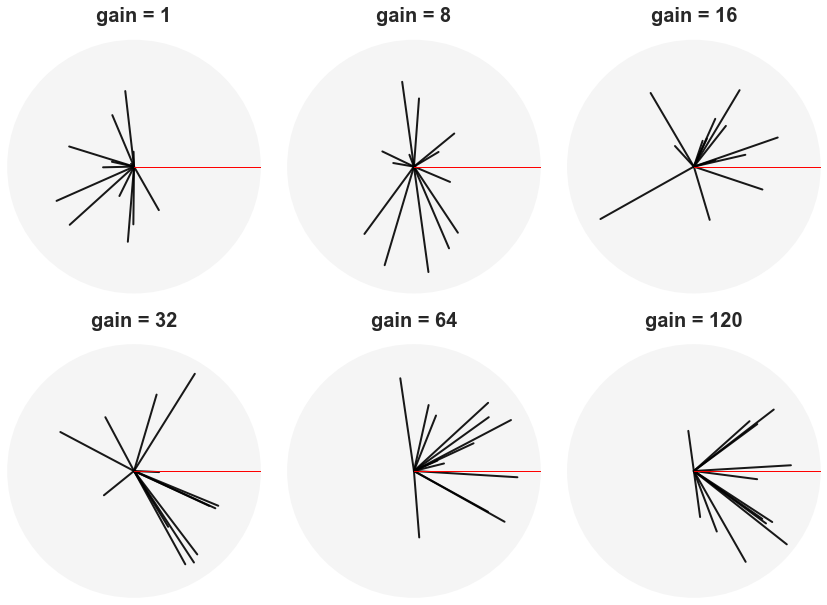

In [25]:
sns.set_style('dark')
fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))

fig.subplots_adjust(hspace = .2, wspace=.01)
axs = axs.ravel()
axisorder = [0,1,2,3,4,5]
g = [1,8,16,32,64,120]
for j in [0,1,2,3,4,5]:
    for i in range(len(all_circmeans_vf)):
        cms = all_circmeans_vf[i][j*2]
        cvs = all_circvars_vf[i][j*2]
        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 0.9, color = 'k', linewidth =2)#, s = 30, alpha = 0.9, color = 'k')
        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(False)
        axs[axisorder[j]].set_rlim(0,1) 
        axs[axisorder[j]].set_title('gain = '+str(g[j]),fontsize = 20, fontweight='bold')
        axs[axisorder[j]].patch.set_facecolor('whitesmoke')
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15)

In [ ]:
for j in [0,2,4,6,8,10]:
    
    fig, ax1 = plt.subplots(1,1,figsize=(15, 7))
    
    for i in range(len(allangles_vf)):
        
        ax1.axvspan(350, len(anglestp), color='darkseagreen')
        framestp = allframes_norm[i][all_sorted_start_frames[i][j]:all_sorted_end_frames[i][j]]
        anglestp = allangles[i][all_sorted_start_frames[i][j]-250:all_sorted_end_frames[i][j]]
        
#         plt.yticks([ts_all_broken_keys[i][j]], fontsize = 30)
        plt.xticks([])
        plt.yticks([])
        x1 = [350,len(anglestp)-1]
        squad = ['0','60']
        
        y1 = [ts_all_broken_keys[i][j]]
        squadd = ['0']
        ax1.set_yticks(y1)
        ax1.set_xticks(x1)
        ax1.set_xticklabels(squad, minor=False, rotation=0, fontsize = 36)
        ax1.set_yticklabels(squadd, minor=False, rotation=0, fontsize = 36)
        ax1.set_xlabel('Time (secs)', fontsize = 36, fontweight = 'bold')
        ax1.set_ylabel('Angles (deg)', fontsize = 36, fontweight = 'bold')
        ax1.plot((350, len(anglestp)), (ts_all_broken_keys[i][j], ts_all_broken_keys[i][j]), 'k-',  linewidth= 4, zorder = 200)
        
        ax1.axvspan(350, len(anglestp), alpha=0.015, color='green')
        ax1.axvspan(0, 350, alpha=0.02, color='white')
        #ax1.set_title(str(ts_all_broken_keys[i][j])+' deg',fontsize = 16, fontweight = 'bold' )
        ax1.tick_params(direction='out', length=15, width=2)
        ax1.spines['left'].set_position(('outward',20))
        # ax5.spines['left'].set_smart_bounds(True)
        # ax5.spines['bottom'].set_smart_bounds(True)
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        
        plt.plot(anglestp, color = 'k', linewidth= 3)
        
        plt.ylim(-200, 200)
#         plt.yticks(np.arange(-180, 225,45), fontsize = 16)
        sns.despine(top=True, right=True, left=False, bottom=False,)

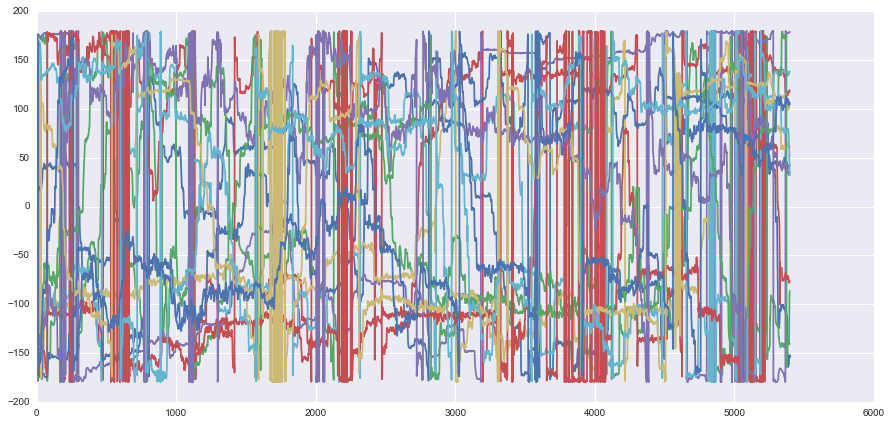

In [206]:
j = 0
plt.figure(figsize = (15,7))
for i in range(len(allangles_vf)):
    #plt.figure(figsize = (15,7))
    plt.plot(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])

In [168]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

In [148]:
# for i in range(len(all_magnotether_angle)):
#     plt.figure()
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [16]:
# #dropping frames
# times = all_magnotether_tstamps

# for i in range(len(times)):
#     plt.figure(figsize = (15,5))
#     plt.scatter(np.arange(0, len(times[i])-1, 1), np.diff(times[i]))
#     #plt.ylim(0,0.2)
#     plt.title('timestamps')
#     frames_dropped = []
#     for j in range(len(np.diff(times[i]))):
#         if (np.diff(times[i]))[j]>0.06:
#             frames_dropped.append(i)
#             #print((np.diff(times[i]))[j])
#     print('percent dropped')
#     print(len(frames_dropped)*100/len(times[i]))

# times = all_magnotether_ros_tstamps

# for i in range(len(times)):
#     plt.figure(figsize = (15,5))
#     plt.scatter(np.arange(0, len(times[i])-1, 1), np.diff(times[i]))
#     #plt.ylim(0,0.2)
#     #plt.xlim(0,500)
#     plt.title('ros timestamps')
#     frames_dropped = []
#     for j in range(len(np.diff(times[i]))):
#         if (np.diff(times[i]))[j]>0.06:
#             frames_dropped.append(i)
#             #print((np.diff(times[i]))[j])
#     print('percent dropped')
#     print(len(frames_dropped))
#     print(len(frames_dropped)*100/len(times[i]))    

In [18]:
#get which patterns where presented
number_trials = 7
#Get panel angle from init angle
all_init_angle_pats = []
for i in range(len(datapaths)):
    ang_panel_pattern_trials = []
    for j in range((number_trials)):
        ang_panel_pattern = all_init_angle[i][np.where(all_trial_index[i]==j)][0]
        ang_panel_pattern_trials.append(ang_panel_pattern)
    all_init_angle_pats.append(ang_panel_pattern_trials)

all_pats = []
for i in range(len(datapaths)):
    pats_trials = []
    for j in [1,2,3,4]:
        if -180<=all_init_angle_pats[i][j]<=-90:
            p=90
        elif -90<=all_init_angle_pats[i][j]<=0:
            p=180
        elif 0<=all_init_angle_pats[i][j]<=90:
            p=-90
        elif 90<=all_init_angle_pats[i][j]<=180:
            p=0
        pats_trials.append(p)
    all_pats.append(pats_trials)
print(all_pats)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [56]:
# i = 0
# j= 0
# plt.figure()
# ang = allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# times = alltimes[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# plt.plot(times, ang)

# i = 0
# j= 1
# plt.figure()
# ang = allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# times = alltimes[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# plt.plot(times, ang)

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

sizes = [22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5,22.5]
sizes = [45, 45, 45, 45, 45, 45, 45, 45]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=False, startangle=0, colors = 'w')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.rcParams['patch.linewidth'] = 6.5
plt.show()

In [ ]:
sns.set()
sns.set_style('white')
sns.despine()
def create_circle():
    circle= plt.Circle((0,0), radius= 5, color = 'darkseagreen', alpha = 1.0)
    return circle

def show_shape(patch):
    ax=plt.gca()
    ax.add_patch(patch)
    plt.axis('scaled')
    plt.xticks([])
    plt.yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

    
    
c= create_circle()
show_shape(c)

In [ ]:
#replace pattern_ids with angles in lab corrdinates

all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        if -22.5<=all_pattern_id[i][j]<=0:
            p=180
        elif 0<=all_pattern_id[i][j]<=22.5:
            p=180
        elif 22.5<=all_pattern_id[i][j]<=67.5:
            p=-135
        elif 67.5<=all_pattern_id[i][j]<=112.5:
            p=-90
        elif 112.5<=all_pattern_id[i][j]<=157.5:
            p=-45
        elif 157.5<=all_pattern_id[i][j]<=180.0:
            p=0
        elif -180.0<=all_pattern_id[i][j]<=-157.5:
            p=0
        elif -157.5<=all_pattern_id[i][j]<=-112.5:
            p=45
        elif -112.5<=all_pattern_id[i][j]<=-67.5:
            p=90
        elif -67.5<=all_pattern_id[i][j]<=-22.5:
            p=135
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)
print(all_pat_angles[0])